# Task 3: Time Series Analysis

ECG time series preprocessing and analysis.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.fft import fft
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

try:
    import wfdb
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wfdb"])
    import wfdb

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

base_path = Path.cwd()
# If running from code directory, go up one level to find Data folder
if base_path.name == 'code':
    base_path = base_path.parent
data_path = base_path / 'Data'
code_path = base_path / 'code'
ecg_data_path = data_path / 'time-series-project2025'

print(f"Working directory: {base_path}")
print(f"Data path: {data_path}")
print(f"ECG data path: {ecg_data_path}")


Working directory: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi
Data path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data
ECG data path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/time-series-project2025


## 1. Load ECG Data


In [2]:
def load_wfdb_ecg_data(ecg_data_path, channel_idx=1, min_samples=100):
    """Load ECG signals from WFDB files."""
    time_series_dict = {}
    ecg_data_path = Path(ecg_data_path)
    
    if not ecg_data_path.exists():
        raise FileNotFoundError(f"ECG data path not found: {ecg_data_path}")
    
    # Get all patient directories
    patient_dirs = [d for d in ecg_data_path.iterdir() if d.is_dir() and '_' in d.name]
    
    print(f"Found {len(patient_dirs)} patient directories")
    print(f"Loading ECG channel {channel_idx} (Lead II)...")
    
    channel_names = ['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    print(f"Extracting channel: {channel_names[channel_idx]}")
    
    loaded_count = 0
    skipped_count = 0
    
    for patient_dir in patient_dirs:
        try:
            # Extract subject_id and hadm_id from directory name (format: subject_id_hadm_id)
            parts = patient_dir.name.split('_')
            if len(parts) < 2:
                continue
            
            subject_id = int(parts[0])
            hadm_id = int(parts[1])
            
            # Find .hea and .dat files (they should have the hadm_id as name)
            hea_file = patient_dir / f"{hadm_id}.hea"
            dat_file = patient_dir / f"{hadm_id}.dat"
            
            if not hea_file.exists() or not dat_file.exists():
                # Try alternative: look for any .hea file in directory
                hea_files = list(patient_dir.glob("*.hea"))
                if not hea_files:
                    skipped_count += 1
                    continue
                hea_file = hea_files[0]
                dat_file = hea_file.with_suffix('.dat')
                if not dat_file.exists():
                    skipped_count += 1
                    continue
            
            # Read WFDB record
            record_name = str(hea_file.with_suffix(''))
            signals, fields = wfdb.rdsamp(record_name, channels=[channel_idx])
            
            # Extract signal data
            signal_data = signals[:, 0]  # Get the selected channel
            
            with open(hea_file, 'r') as f:
                header_lines = f.readlines()
            
            first_line = header_lines[0].strip().split()
            if len(first_line) >= 4:
                sampling_freq = float(first_line[2])
                num_samples = int(first_line[3])
                
                # Parse start time and date if available
                start_time_str = first_line[4] if len(first_line) > 4 else "00:00:00"
                date_str = first_line[5] if len(first_line) > 5 else "01/01/2000"
                
                # Parse date and time
                try:
                    # Date format: MM/DD/YYYY or DD/MM/YYYY
                    date_parts = date_str.split('/')
                    if len(date_parts) == 3:
                        # Assume MM/DD/YYYY format
                        month, day, year = int(date_parts[0]), int(date_parts[1]), int(date_parts[2])
                    else:
                        month, day, year = 1, 1, 2000
                    
                    # Time format: HH:MM:SS
                    time_parts = start_time_str.split(':')
                    if len(time_parts) >= 2:
                        hour, minute = int(time_parts[0]), int(time_parts[1])
                        second = int(time_parts[2]) if len(time_parts) > 2 else 0
                    else:
                        hour, minute, second = 0, 0, 0
                    
                    from datetime import datetime
                    start_datetime = datetime(year, month, day, hour, minute, second)
                except:
                    from datetime import datetime
                    start_datetime = datetime(2000, 1, 1, 0, 0, 0)
            else:
                sampling_freq = 500.0  # Default
                num_samples = len(signal_data)
                from datetime import datetime
                start_datetime = datetime(2000, 1, 1, 0, 0, 0)
            
            if len(signal_data) < min_samples:
                skipped_count += 1
                continue
            
            time_delta = pd.Timedelta(seconds=1/sampling_freq)
            timestamps = [start_datetime + i * time_delta for i in range(len(signal_data))]
            
            # Create DataFrame in the same format as the original notebook
            ts_df = pd.DataFrame({
                'charttime': timestamps,
                'valuenum': signal_data
            })
            
            time_series_dict[subject_id] = ts_df
            loaded_count += 1
            
            if loaded_count % 100 == 0:
                print(f"Loaded {loaded_count} patients...")
                
        except Exception as e:
            skipped_count += 1
            if skipped_count <= 5:  # Only print first few errors
                print(f"Error loading {patient_dir.name}: {str(e)}")
            continue
    
    print(f"\nSuccessfully loaded {loaded_count} patients")
    print(f"Skipped {skipped_count} patients")
    return time_series_dict

# Load ECG data
time_series_dict = load_wfdb_ecg_data(ecg_data_path, channel_idx=1, min_samples=100)

print(f"\nTotal patients with ECG time series: {len(time_series_dict):,}")
if len(time_series_dict) > 0:
    first_subject = list(time_series_dict.keys())[0]
    print(f"\nExample time series for subject {first_subject}:")
    print(time_series_dict[first_subject].head(10))
    print(f"\nTime series length: {len(time_series_dict[first_subject]):,} samples")
    print(f"Time range: {time_series_dict[first_subject]['charttime'].min()} to {time_series_dict[first_subject]['charttime'].max()}")


Found 1786 patient directories
Loading ECG channel 1 (Lead II)...
Extracting channel: II
Loaded 100 patients...
Loaded 200 patients...
Loaded 300 patients...
Loaded 400 patients...
Loaded 500 patients...
Loaded 600 patients...
Loaded 700 patients...
Loaded 800 patients...
Loaded 900 patients...
Loaded 1000 patients...
Loaded 1100 patients...
Loaded 1200 patients...
Loaded 1300 patients...
Loaded 1400 patients...
Loaded 1500 patients...
Loaded 1600 patients...
Loaded 1700 patients...

Successfully loaded 1786 patients
Skipped 0 patients

Total patients with ECG time series: 1,786

Example time series for subject 14582002:
                charttime  valuenum
0 2000-01-01 00:00:00.000  0.031383
1 2000-01-01 00:00:00.002  0.032887
2 2000-01-01 00:00:00.004  0.020256
3 2000-01-01 00:00:00.006  0.027715
4 2000-01-01 00:00:00.008  0.036823
5 2000-01-01 00:00:00.010  0.042448
6 2000-01-01 00:00:00.012  0.045848
7 2000-01-01 00:00:00.014  0.041109
8 2000-01-01 00:00:00.016  0.043849
9 2000-01-0

## 2. Data Summary


In [3]:
# ECG-specific filtering functions
def ecg_bandpass_filter(signal, fs=500, lowcut=0.5, highcut=40):
    """Remove baseline wander and high-frequency noise using bandpass filter.
    
    Args:
        signal: ECG signal array
        fs: Sampling frequency (Hz), default 500
        lowcut: Low cutoff frequency (Hz), default 0.5
        highcut: High cutoff frequency (Hz), default 40
    
    Returns:
        Filtered signal
    """
    nyq = fs / 2
    if len(signal) < 4:  # Need minimum samples for filter
        return signal
    
    try:
        b, a = butter(4, [lowcut/nyq, highcut/nyq], btype='band')
        filtered = filtfilt(b, a, signal)
        return filtered
    except:
        # Fallback if filtering fails
        return signal

def ecg_notch_filter(signal, fs=500, freq=60):
    """Remove powerline interference (60Hz US, 50Hz EU).
    
    Args:
        signal: ECG signal array
        fs: Sampling frequency (Hz), default 500
        freq: Notch frequency (Hz), default 60
    
    Returns:
        Filtered signal
    """
    if len(signal) < 4:
        return signal
    
    try:
        # Quality factor Q = 30 for narrow notch
        b, a = iirnotch(freq, 30, fs)
        filtered = filtfilt(b, a, signal)
        return filtered
    except:
        return signal

print("ECG filtering functions defined.")

ECG filtering functions defined.


In [4]:
print(f"ECG time series loaded: {len(time_series_dict):,} patients")
print(f"\nECG signal statistics:")

all_lengths = [len(ts) for ts in time_series_dict.values()]
all_values = np.concatenate([ts['valuenum'].values for ts in time_series_dict.values()])

print(f"  - Number of patients: {len(time_series_dict):,}")
print(f"  - Signal length range: {min(all_lengths):,} to {max(all_lengths):,} samples")
print(f"  - Mean signal length: {np.mean(all_lengths):.1f} samples")
print(f"  - Signal value statistics:")
print(f"    Mean: {np.mean(all_values):.2f} mV")
print(f"    Std: {np.std(all_values):.2f} mV")
print(f"    Min: {np.min(all_values):.2f} mV")
print(f"    Max: {np.max(all_values):.2f} mV")


ECG time series loaded: 1,786 patients

ECG signal statistics:
  - Number of patients: 1,786
  - Signal length range: 5,000 to 5,000 samples
  - Mean signal length: 5000.0 samples
  - Signal value statistics:
    Mean: 0.01 mV
    Std: 0.16 mV
    Min: -1.53 mV
    Max: 2.27 mV


In [5]:
# Each time series represents Lead II channel (channel index 1) from the 12-lead ECG

print("Sample ECG time series statistics for first 5 patients:")
for i, (subject_id, ts) in enumerate(list(time_series_dict.items())[:5]):
    print(f"\n  Subject {subject_id}:")
    print(f"    - Length: {len(ts):,} samples")
    print(f"    - Duration: {(ts['charttime'].max() - ts['charttime'].min()).total_seconds():.2f} seconds")
    print(f"    - Value range: {ts['valuenum'].min():.2f} to {ts['valuenum'].max():.2f} mV")
    print(f"    - Mean: {ts['valuenum'].mean():.2f} mV, Std: {ts['valuenum'].std():.2f} mV")


Sample ECG time series statistics for first 5 patients:

  Subject 14582002:
    - Length: 5,000 samples
    - Duration: 10.00 seconds
    - Value range: -0.49 to 0.86 mV
    - Mean: 0.02 mV, Std: 0.14 mV

  Subject 15789257:
    - Length: 5,000 samples
    - Duration: 10.00 seconds
    - Value range: -0.39 to 0.34 mV
    - Mean: 0.02 mV, Std: 0.10 mV

  Subject 18538902:
    - Length: 5,000 samples
    - Duration: 10.00 seconds
    - Value range: -0.17 to 0.47 mV
    - Mean: 0.03 mV, Std: 0.09 mV

  Subject 11959580:
    - Length: 5,000 samples
    - Duration: 10.00 seconds
    - Value range: -0.32 to 0.74 mV
    - Mean: 0.02 mV, Std: 0.11 mV

  Subject 15225006:
    - Length: 5,000 samples
    - Duration: 10.00 seconds
    - Value range: -0.39 to 0.35 mV
    - Mean: 0.02 mV, Std: 0.10 mV


In [6]:
# Each entry is a DataFrame with 'charttime' and 'valuenum' columns

print(f"Subjects with ECG time series (≥100 samples): {len(time_series_dict):,}")
if len(time_series_dict) > 0:
    first_subject = list(time_series_dict.keys())[0]
    print(f"\nExample time series for subject {first_subject}:")
    print(time_series_dict[first_subject].head(10))
    print(f"\nTime series length: {len(time_series_dict[first_subject]):,} samples")


Subjects with ECG time series (≥100 samples): 1,786

Example time series for subject 14582002:
                charttime  valuenum
0 2000-01-01 00:00:00.000  0.031383
1 2000-01-01 00:00:00.002  0.032887
2 2000-01-01 00:00:00.004  0.020256
3 2000-01-01 00:00:00.006  0.027715
4 2000-01-01 00:00:00.008  0.036823
5 2000-01-01 00:00:00.010  0.042448
6 2000-01-01 00:00:00.012  0.045848
7 2000-01-01 00:00:00.014  0.041109
8 2000-01-01 00:00:00.016  0.043849
9 2000-01-01 00:00:00.018  0.047785

Time series length: 5,000 samples


## 3. Preprocessing


In [7]:
def preprocess_time_series(ts_values, fs=500, apply_trend_removal=True, apply_ecg_filtering=True):
    """Preprocess ECG time series: offset removal, scaling, detrending, ECG-specific filtering.
    
    Args:
        ts_values: ECG signal values
        fs: Sampling frequency (Hz), default 500
        apply_trend_removal: Whether to remove linear trend
        apply_ecg_filtering: Whether to apply ECG bandpass and notch filters
    """
    values = ts_values.copy()
    original_values = values.copy()
    
    # Step 1: Offset Translation Removal
    mean_val = np.mean(values)
    values_step1 = values - mean_val
    
    # Step 2: Amplitude Scaling (z-normalization)
    std_val = np.std(values)
    if std_val > 0:
        values_step2 = values_step1 / std_val
    else:
        values_step2 = values_step1
    
    # Step 3: Linear Trend Removal
    if apply_trend_removal and len(values) > 2:
        x = np.arange(len(values))
        slope, intercept = np.polyfit(x, values_step2, 1)
        trend = slope * x + intercept
        values_step3 = values_step2 - trend
    else:
        values_step3 = values_step2
        trend = None
    
    # Step 4: ECG-specific filtering (bandpass + notch)
    if apply_ecg_filtering:
        # Apply bandpass filter (0.5-40 Hz) to remove baseline wander and high-freq noise
        values_step4a = ecg_bandpass_filter(values_step3, fs=fs, lowcut=0.5, highcut=40)
        # Apply notch filter (60 Hz) to remove powerline interference
        values_step4 = ecg_notch_filter(values_step4a, fs=fs, freq=60)
    else:
        values_step4 = values_step3
    
    return {
        'original': original_values,
        'after_offset': values_step1,
        'after_scaling': values_step2,
        'after_trend': values_step3,
        'after_ecg_filter': values_step4,
        'trend': trend if apply_trend_removal else None
    }

sample_subject = list(time_series_dict.keys())[0]
sample_ts = time_series_dict[sample_subject]
preprocessed = preprocess_time_series(sample_ts['valuenum'].values)

print(f"Preprocessing example for subject {sample_subject}:")
print(f"Original mean: {preprocessed['original'].mean():.2f}, std: {preprocessed['original'].std():.2f}")
print(f"After scaling mean: {preprocessed['after_scaling'].mean():.2f}, std: {preprocessed['after_scaling'].std():.2f}")


Preprocessing example for subject 14582002:
Original mean: 0.02, std: 0.14
After scaling mean: 0.00, std: 1.00


In [8]:
preprocessed_series = {}
for subject_id, ts in time_series_dict.items():
    preprocessed = preprocess_time_series(ts['valuenum'].values)
    preprocessed_series[subject_id] = {
        'timestamps': ts['charttime'].values,
        'original': ts['valuenum'].values,
        'preprocessed': preprocessed['after_ecg_filter'],
        'all_steps': preprocessed
    }

print(f"Preprocessed {len(preprocessed_series):,} time series")


Preprocessed 1,786 time series


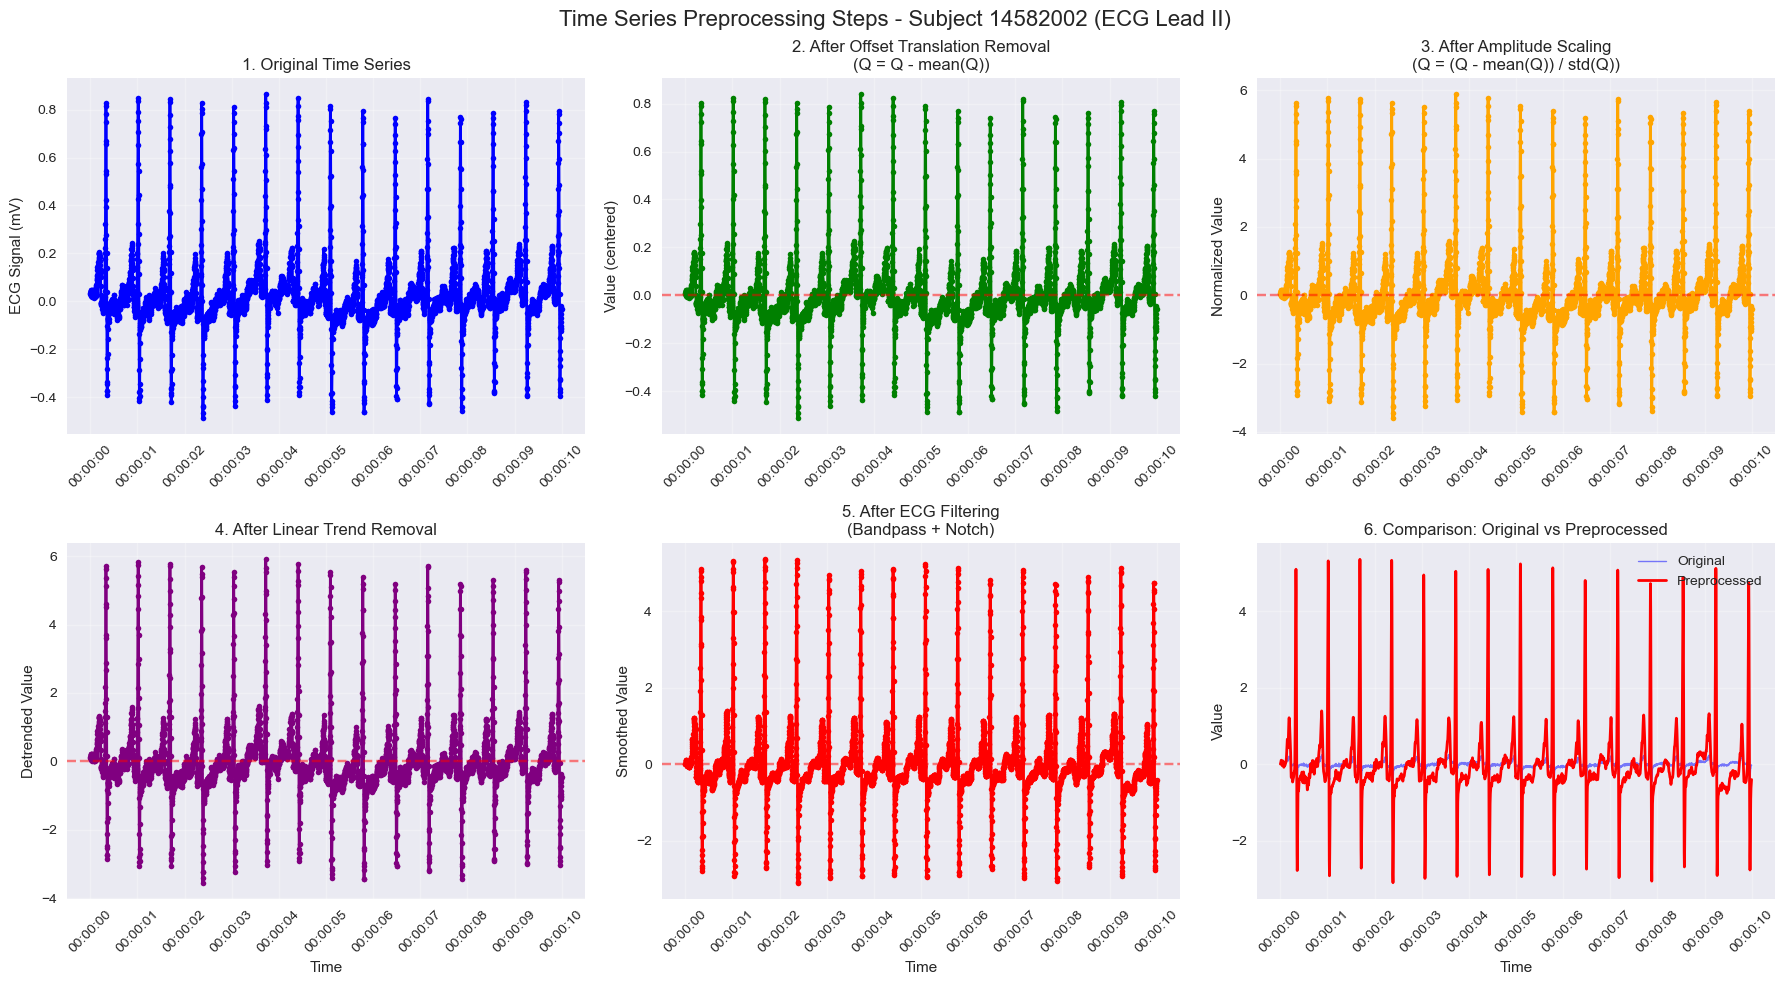

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Time Series Preprocessing Steps - Subject {sample_subject} (ECG Lead II)', fontsize=16)

sample_data = preprocessed_series[sample_subject]
steps = sample_data['all_steps']
timestamps = sample_data['timestamps']

# Plot original
axes[0, 0].plot(timestamps, steps['original'], 'b-', linewidth=2, marker='o', markersize=4)
axes[0, 0].set_title('1. Original Time Series')
axes[0, 0].set_ylabel('ECG Signal (mV)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot after offset removal
axes[0, 1].plot(timestamps, steps['after_offset'], 'g-', linewidth=2, marker='o', markersize=4)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 1].set_title('2. After Offset Translation Removal\n(Q = Q - mean(Q))')
axes[0, 1].set_ylabel('Value (centered)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot after scaling
axes[0, 2].plot(timestamps, steps['after_scaling'], 'orange', linewidth=2, marker='o', markersize=4)
axes[0, 2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 2].set_title('3. After Amplitude Scaling\n(Q = (Q - mean(Q)) / std(Q))')
axes[0, 2].set_ylabel('Normalized Value')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].tick_params(axis='x', rotation=45)

# Plot after trend removal
axes[1, 0].plot(timestamps, steps['after_trend'], 'purple', linewidth=2, marker='o', markersize=4)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_title('4. After Linear Trend Removal')
axes[1, 0].set_ylabel('Detrended Value')
axes[1, 0].set_xlabel('Time')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot after noise filtering
axes[1, 1].plot(timestamps, steps['after_ecg_filter'], 'red', linewidth=2, marker='o', markersize=4)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_title('5. After ECG Filtering\n(Bandpass + Notch)')
axes[1, 1].set_ylabel('Smoothed Value')
axes[1, 1].set_xlabel('Time')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# Plot comparison: original vs final
axes[1, 2].plot(timestamps, steps['original'], 'b-', linewidth=1, alpha=0.5, label='Original')
axes[1, 2].plot(timestamps, steps['after_ecg_filter'], 'r-', linewidth=2, label='Preprocessed')
axes[1, 2].set_title('6. Comparison: Original vs Preprocessed')
axes[1, 2].set_ylabel('Value')
axes[1, 2].set_xlabel('Time')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(code_path / 'time_series_preprocessing_steps.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
import pickle

# Export preprocessed time series data for use in other notebooks
# This eliminates the need to reload and preprocess data in notebooks 5 and 6

# Create equal-length time series for notebook 5 (clustering)
# Notebook 5 expects 100 timepoints, z-normalized
n_timepoints_equal = 100
time_grid = np.linspace(0.0, 1.0, n_timepoints_equal)

subject_ids_list = []
preprocessed_equal_length = []
preprocessed_original_length = []

for subject_id in sorted(preprocessed_series.keys()):
    data = preprocessed_series[subject_id]
    preprocessed_ts = data['preprocessed']
    timestamps = data['timestamps']
    
    # Store original-length preprocessed series (for notebook 6)
    preprocessed_original_length.append(preprocessed_ts)
    
    # Create equal-length version for notebook 5
    # Normalize timestamps to [0, 1]
    times_numeric = pd.to_datetime(timestamps).view('int64').astype(float)
    t_min, t_max = times_numeric.min(), times_numeric.max()
    
    if t_max == t_min:
        continue
    
    t_norm = (times_numeric - t_min) / (t_max - t_min)
    
    # Interpolate to equal-length grid
    interp_values = np.interp(time_grid, t_norm, preprocessed_ts)
    
    # Apply z-normalization (notebook 5 does this, but we'll do it here for consistency)
    mean = interp_values.mean()
    std = interp_values.std()
    if std > 0:
        z_normalized = (interp_values - mean) / std
    else:
        z_normalized = interp_values
    
    preprocessed_equal_length.append(z_normalized)
    subject_ids_list.append(subject_id)

# Convert to numpy arrays
subject_ids_array = np.array(subject_ids_list)
X_preprocessed_equal = np.vstack(preprocessed_equal_length)  # Shape: (n_subjects, 100)
X_preprocessed_original = np.array(preprocessed_original_length, dtype=object)  # Variable lengths

# Create export dictionary
preprocessed_data_export = {
    'subject_ids': subject_ids_array,
    'preprocessed_equal_length': X_preprocessed_equal,  # For notebook 5: shape (n_subjects, 100)
    'preprocessed_original_length': X_preprocessed_original,  # For notebook 6: variable lengths
    'metadata': {
        'n_subjects': len(subject_ids_array),
        'equal_length_n_timepoints': n_timepoints_equal,
        'preprocessing_steps': [
            'offset_translation_removal',
            'amplitude_scaling_z_normalization',
            'linear_trend_removal',
            'ecg_bandpass_filter_0.5_40hz',
            'ecg_notch_filter_60hz'
        ],
        'preprocessing_params': {
            'apply_trend_removal': True,
            'apply_ecg_filtering': True,
            'sampling_frequency': 500
        },
        'export_date': pd.Timestamp.now().isoformat()
    }
}

# Export to pickle file
export_path = data_path / 'preprocessed_time_series.pkl'
with open(export_path, 'wb') as f:
    pickle.dump(preprocessed_data_export, f)

print(f"Exported preprocessed time series data to: {export_path}")
print(f"  - Number of subjects: {len(subject_ids_array):,}")
print(f"  - Equal-length shape: {X_preprocessed_equal.shape} (for notebook 5)")
print(f"  - Original-length: {len(X_preprocessed_original)} arrays (for notebook 6)")
print(f"  - Average original length: {np.mean([len(ts) for ts in X_preprocessed_original]):.0f} samples")

Exported preprocessed time series data to: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/preprocessed_time_series.pkl
  - Number of subjects: 1,786
  - Equal-length shape: (1786, 100) (for notebook 5)
  - Original-length: 1786 arrays (for notebook 6)
  - Average original length: 5000 samples


In [11]:
def paa_transform(ts_values, num_segments):
    """Piecewise Aggregate Approximation - average values in equal segments."""
    n = len(ts_values)
    if num_segments >= n:
        return ts_values, np.arange(n)
    
    segment_size = n / num_segments
    paa_values = []
    segment_indices = [0]
    
    for i in range(num_segments):
        start_idx = int(i * segment_size)
        end_idx = int((i + 1) * segment_size)
        if end_idx > n:
            end_idx = n
        
        # Average of segment
        segment_mean = np.mean(ts_values[start_idx:end_idx])
        paa_values.append(segment_mean)
        
        if i < num_segments - 1:
            segment_indices.append(end_idx)
    
    return np.array(paa_values), np.array(segment_indices)

sample_values = preprocessed_series[sample_subject]['preprocessed']
paa_result, segment_idx = paa_transform(sample_values, num_segments=5)

print(f"Original length: {len(sample_values)}")
print(f"PAA length: {len(paa_result)}")
print(f"PAA values: {paa_result}")
print(f"Compression ratio: {len(sample_values) / len(paa_result):.2f}x")


Original length: 5000
PAA length: 5
PAA values: [ 5.95532501e-04  9.00553915e-05  4.06073206e-03  1.61988169e-03
 -4.99028693e-03]
Compression ratio: 1000.00x


In [ ]:
def sax(time_series, n_segments, alphabet_size=4):
    """SAX: PAA then convert to symbols."""
    # Z-normalize
    ts = np.array(time_series)
    if np.std(ts) == 0:
        ts_norm = ts - np.mean(ts)
    else:
        ts_norm = (ts - np.mean(ts)) / np.std(ts)
    
    # Apply PAA
    paa_values = paa_transform(ts_norm, n_segments)[0]
    
    from scipy.stats import norm
    breakpoints = []
    for i in range(1, alphabet_size):
        breakpoints.append(norm.ppf(i / alphabet_size))
    sax_symbols = []
    for val in paa_values:
        symbol = 0
        for i, bp in enumerate(breakpoints):
            if val > bp:
                symbol = i + 1
        sax_symbols.append(symbol)
    
    return np.array(sax_symbols)

def dft_features(time_series, n_coefficients=20):
    """DFT: Extract Fourier coefficients."""
    ts = np.array(time_series)
    fft_vals = fft(ts)
    n_coeffs = min(n_coefficients, len(fft_vals) // 2)
    dft_features = np.abs(fft_vals[:n_coeffs])
    dft_features = dft_features / len(ts)
    
    return dft_features

# Test SAX and DFT on sample
sample_values = preprocessed_series[sample_subject]['preprocessed']
sax_result = sax(sample_values, num_segments=10, alphabet_size=4)
dft_result = dft_features(sample_values, n_coefficients=10)

print(f"Sample SAX result: {sax_result}")
print(f"Sample DFT result (first 5): {dft_result[:5]}")

Sample SAX result: [2 1 2 1 2 1 2 1 2 1]
Sample DFT result (first 5): [0.00027518 0.00048028 0.00149542 0.00286947 0.01110799]


In [13]:
paa_results = {}
for subject_id, data in preprocessed_series.items():
    ts_values = data['preprocessed']
    # Use approximately 1/3 of original length, but at least 3 and at most 10
    num_segments = max(3, min(10, len(ts_values) // 3))
    paa_values, segment_idx = paa_transform(ts_values, num_segments)
    paa_results[subject_id] = {
        'paa_values': paa_values,
        'num_segments': num_segments,
        'original_length': len(ts_values)
    }

print(f"Applied PAA to {len(paa_results):,} time series")
print(f"\nExample PAA result for subject {sample_subject}:")
print(f"Original length: {paa_results[sample_subject]['original_length']}")
print(f"PAA segments: {paa_results[sample_subject]['num_segments']}")
print(f"PAA values: {paa_results[sample_subject]['paa_values']}")


Applied PAA to 1,786 time series

Example PAA result for subject 14582002:
Original length: 5000
PAA segments: 10
PAA values: [ 0.03423305 -0.03304199  0.02891056 -0.02873045  0.05612828 -0.04800682
  0.02261448 -0.01937471  0.02392227 -0.03390284]


Applied SAX to 1,786 time series

Example SAX result for subject 14582002:
Original length: 5000
SAX segments: 10
SAX symbols: [2 1 2 1 2 1 2 1 2 1]


Applied DFT to 1,786 time series

Example DFT result for subject 14582002:
Original length: 5000
DFT coefficients: 20
DFT values (first 5): [0.00027518 0.00048028 0.00149542 0.00286947 0.01110799]


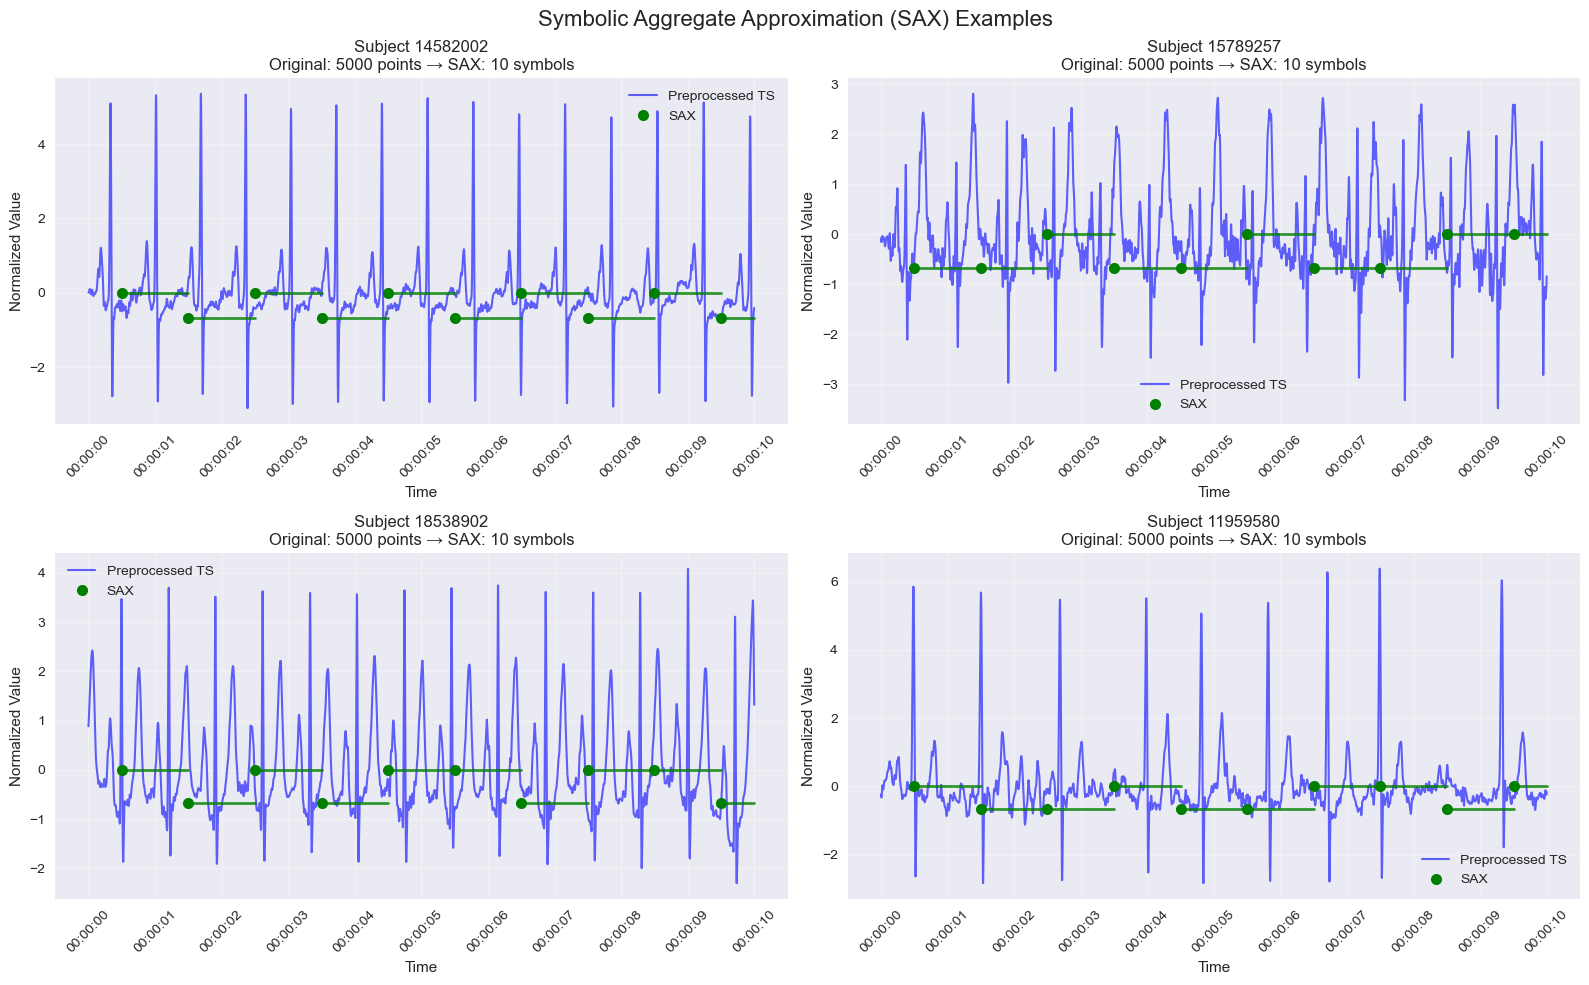

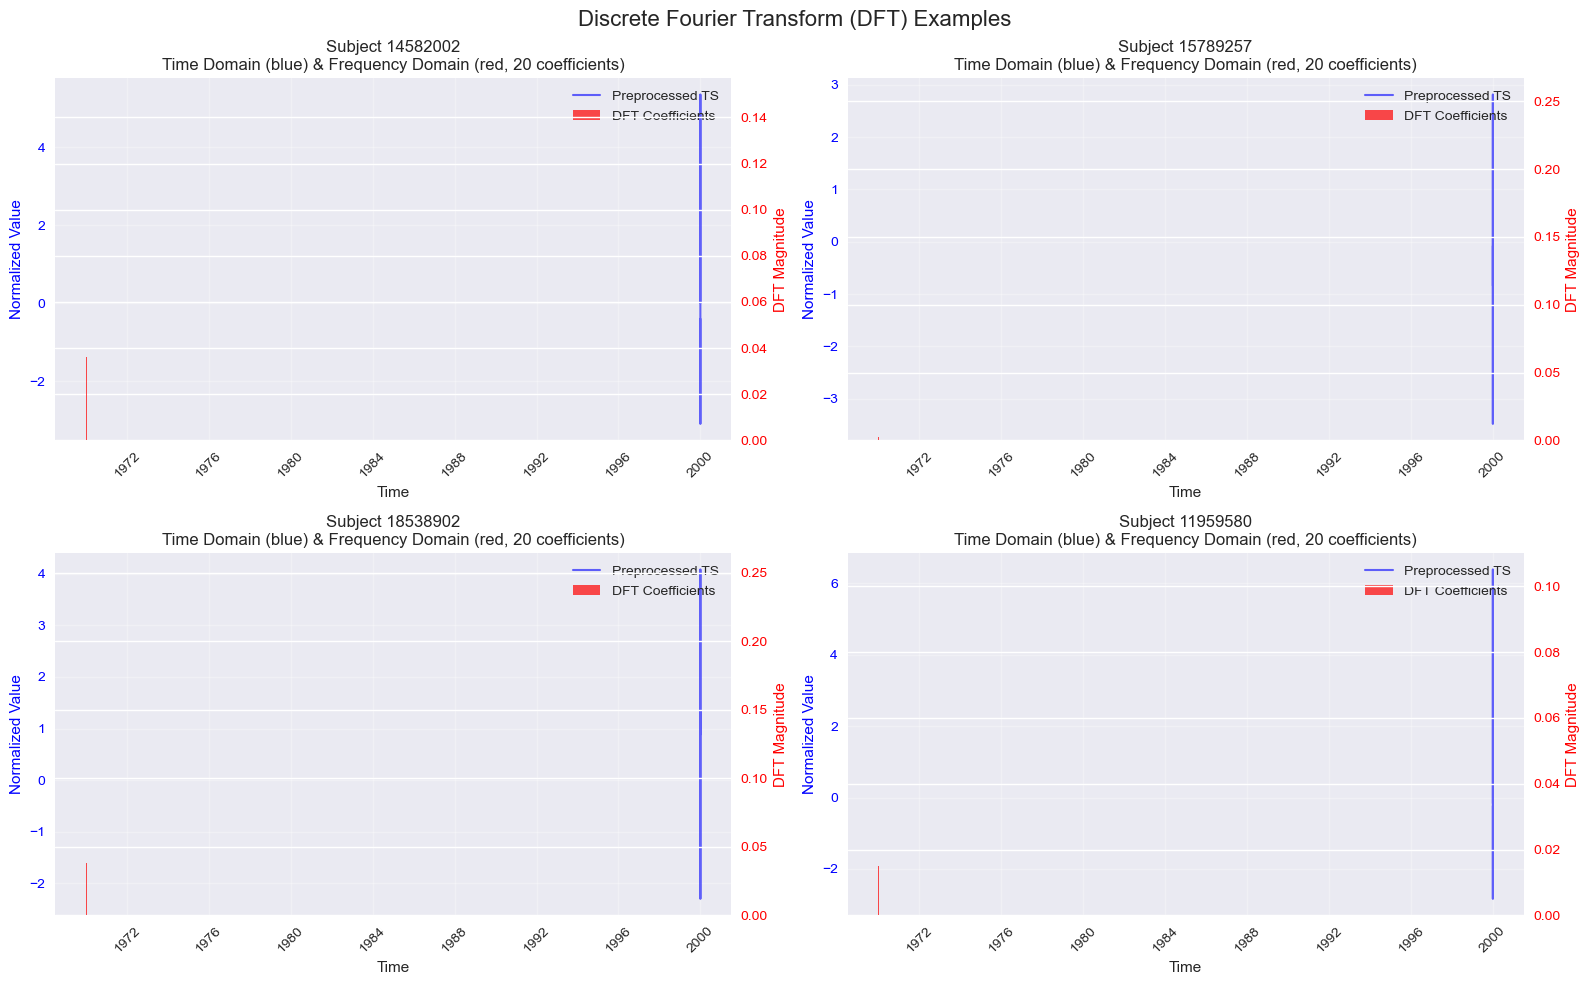

In [ ]:
# Visualize DFT features - Frequency Spectrum using stem plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Discrete Fourier Transform (DFT) Features - Frequency Spectrum', fontsize=16)

# Calculate actual frequencies (ECG data: fs=500 Hz, signal length N=5000 samples)
fs = 500  # sampling frequency (Hz)
N = 5000  # signal length (samples)
n_coefficients = 20  # number of DFT coefficients extracted
frequencies = np.arange(n_coefficients) * fs / N  # Frequency in Hz: 0, 0.1, 0.2, ..., 1.9 Hz

# Select a few subjects to visualize
subjects_to_plot = list(preprocessed_series.keys())[:4]

for idx, subject_id in enumerate(subjects_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Get DFT result for this subject
    dft_vals = dft_results[subject_id]['dft_values']
    original_length = dft_results[subject_id]['original_length']
    
    # Stem plot for frequency components (standard way to visualize DFT)
    markerline, stemlines, baseline = ax.stem(
        frequencies, 
        dft_vals, 
        linefmt='b-', 
        markerfmt='bo', 
        basefmt='k-'
    )
    
    # Customize stem plot appearance
    plt.setp(stemlines, 'linewidth', 1.5)
    plt.setp(markerline, 'markersize', 6)
    plt.setp(baseline, 'linewidth', 0.5)
    
    ax.set_xlabel('Frequency (Hz)', fontsize=11)
    ax.set_ylabel('Magnitude', fontsize=11)
    ax.set_title(f'Subject {subject_id}\nDFT: {n_coefficients} coefficients from {original_length} samples', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim([-0.1, frequencies[-1] + 0.1])
    
    # Add frequency labels on x-axis
    ax.set_xticks(frequencies[::2])  # Show every other frequency for readability
    ax.set_xticklabels([f'{freq:.1f}' for freq in frequencies[::2]])

plt.tight_layout()
plt.savefig(code_path / 'time_series_dft_spectrum.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nDFT Visualization:")
print(f"  - Sampling frequency: {fs} Hz")
print(f"  - Signal length: {N} samples")
print(f"  - Frequency resolution: {fs/N:.3f} Hz per bin")
print(f"  - Frequency range: 0 to {frequencies[-1]:.1f} Hz")
print(f"  - Number of coefficients: {n_coefficients}")

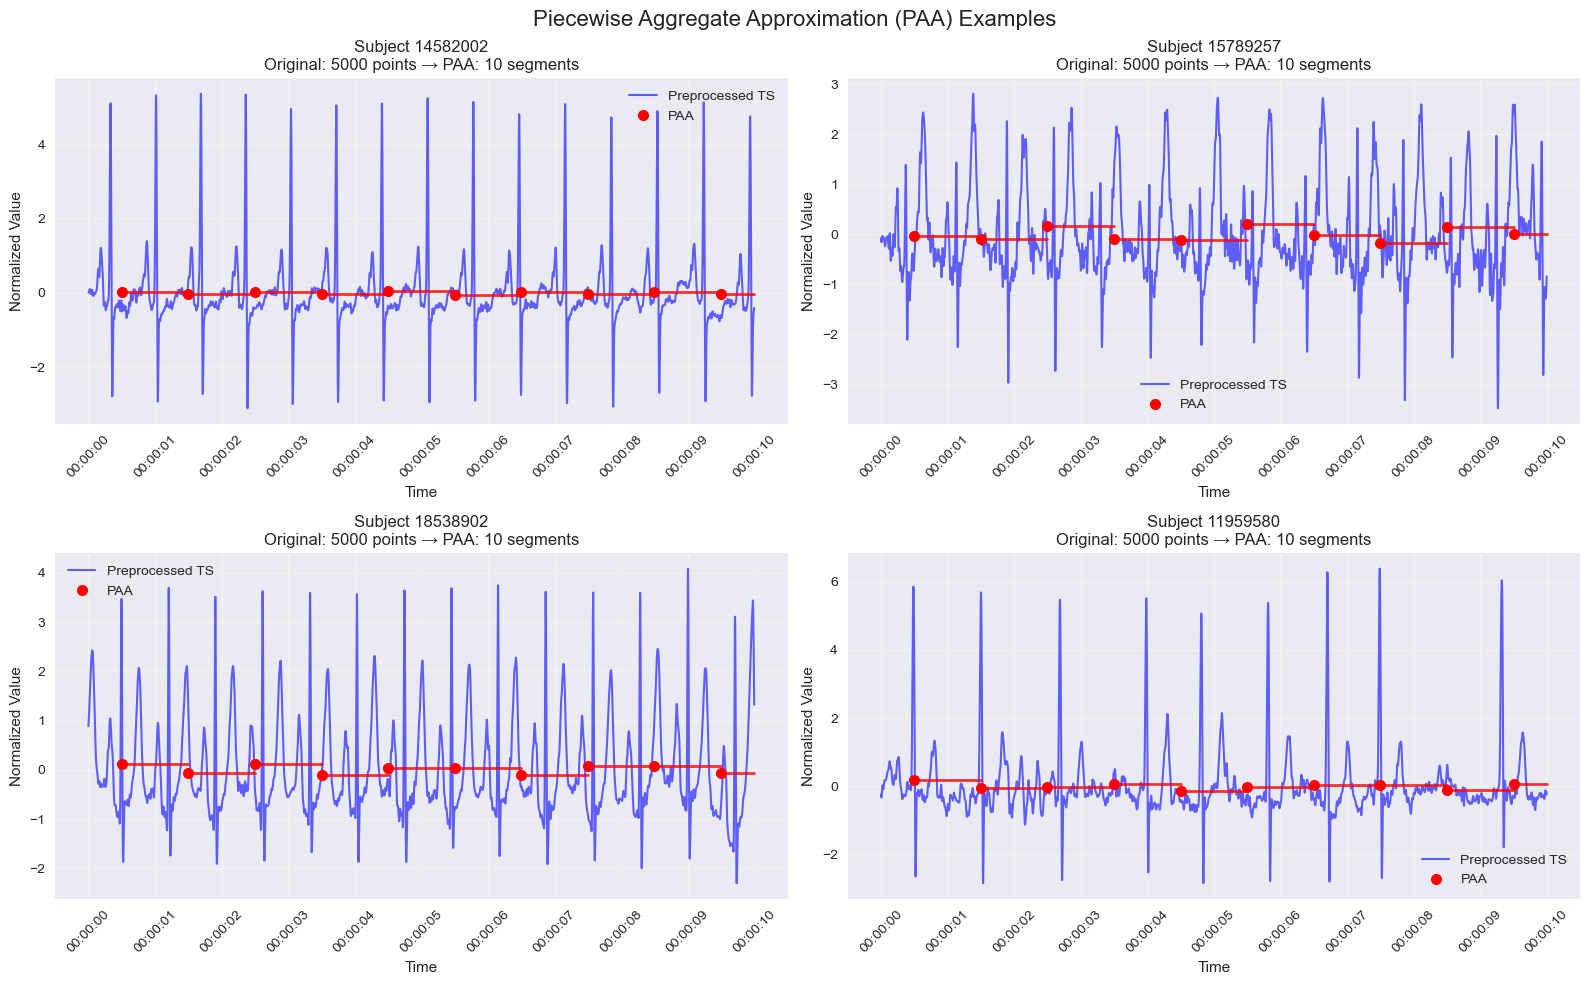

In [18]:
# Visualize PAA approximation
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Piecewise Aggregate Approximation (PAA) Examples', fontsize=16)

# Select a few subjects to visualize
subjects_to_plot = list(preprocessed_series.keys())[:4]

for idx, subject_id in enumerate(subjects_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    data = preprocessed_series[subject_id]
    timestamps = data['timestamps']
    original = data['preprocessed']
    
    # Get PAA result
    paa_vals = paa_results[subject_id]['paa_values']
    num_segments = paa_results[subject_id]['num_segments']
    
    # Reconstruct PAA time series for visualization
    segment_size = len(original) / num_segments
    paa_timestamps = []
    paa_reconstructed = []
    
    for i in range(num_segments):
        start_idx = int(i * segment_size)
        end_idx = int((i + 1) * segment_size)
        if end_idx > len(original):
            end_idx = len(original)
        
        # Use midpoint timestamp of segment
        mid_idx = (start_idx + end_idx) // 2
        paa_timestamps.append(timestamps[mid_idx])
        paa_reconstructed.append(paa_vals[i])
    
    # Plot original
    ax.plot(timestamps, original, 'b-', linewidth=1.5, alpha=0.6, label='Preprocessed TS')
    
    # Plot PAA approximation (step function)
    paa_timestamps = np.array(paa_timestamps)
    paa_reconstructed = np.array(paa_reconstructed)
    
    # Create step plot for PAA
    for i in range(len(paa_reconstructed) - 1):
        start_time = paa_timestamps[i]
        end_time = paa_timestamps[i + 1]
        ax.plot([start_time, end_time], [paa_reconstructed[i], paa_reconstructed[i]], 
                'r-', linewidth=2, alpha=0.8)
        if i == 0:
            ax.plot([start_time], [paa_reconstructed[i]], 'ro', markersize=8, label='PAA')
        else:
            ax.plot([start_time], [paa_reconstructed[i]], 'ro', markersize=8)
    
    # Plot last segment
    if len(paa_reconstructed) > 0:
        last_time = timestamps[-1]
        ax.plot([paa_timestamps[-1], last_time], 
                [paa_reconstructed[-1], paa_reconstructed[-1]], 
                'r-', linewidth=2, alpha=0.8)
        ax.plot([paa_timestamps[-1]], [paa_reconstructed[-1]], 'ro', markersize=8)
    
    ax.set_title(f'Subject {subject_id}\nOriginal: {len(original)} points → PAA: {num_segments} segments')
    ax.set_xlabel('Time')
    ax.set_ylabel('Normalized Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(code_path / 'time_series_paa_approximation.png', dpi=300, bbox_inches='tight')
plt.show()


## 6. Feature Extraction


In [19]:
def extract_time_series_features(ts_values):
    """Extract statistical features from time series."""
    features = {}
    
    # Basic statistics
    features['mean'] = np.mean(ts_values)
    features['variance'] = np.var(ts_values)
    features['std'] = np.std(ts_values)
    features['min'] = np.min(ts_values)
    features['max'] = np.max(ts_values)
    features['range'] = features['max'] - features['min']
    features['median'] = np.median(ts_values)
    
    # Trend (slope of linear fit)
    if len(ts_values) > 1:
        x = np.arange(len(ts_values))
        slope, intercept = np.polyfit(x, ts_values, 1)
        features['trend_slope'] = slope
        features['trend_intercept'] = intercept
    else:
        features['trend_slope'] = 0
        features['trend_intercept'] = ts_values[0] if len(ts_values) > 0 else 0
    
    # Auto-covariance (lag-1)
    if len(ts_values) > 1:
        features['autocov_lag1'] = np.cov(ts_values[:-1], ts_values[1:])[0, 1]
    else:
        features['autocov_lag1'] = 0
    
    # Percentiles
    features['q25'] = np.percentile(ts_values, 25)
    features['q75'] = np.percentile(ts_values, 75)
    features['iqr'] = features['q75'] - features['q25']
    
    return features

# Extract features from all preprocessed time series
ts_features = {}
for subject_id, data in preprocessed_series.items():
    ts_values = data['preprocessed']
    features = extract_time_series_features(ts_values)
    ts_features[subject_id] = features

# Convert to DataFrame for easier analysis
features_df = pd.DataFrame.from_dict(ts_features, orient='index')
features_df.index.name = 'subject_id'

print(f"Extracted features from {len(ts_features):,} time series")
print(f"\nFeature statistics:")
print(features_df.describe())


Extracted features from 1,786 time series

Feature statistics:
              mean     variance          std          min          max  \
count  1786.000000  1786.000000  1786.000000  1786.000000  1786.000000   
mean      0.000554     0.873476     0.928820    -2.367360     4.940146   
std       0.007738     0.168222     0.103805     0.931196     2.118010   
min      -0.019882     0.288194     0.536837    -4.593698     1.557838   
25%      -0.004590     0.847271     0.920473    -3.080011     3.316083   
50%       0.000556     0.930954     0.964859    -2.145225     5.291066   
75%       0.004467     0.968594     0.984172    -1.781336     6.332692   
max       0.020199     1.100213     1.048910    -0.658685    11.046915   

             range       median   trend_slope  trend_intercept  autocov_lag1  \
count  1786.000000  1786.000000  1.786000e+03      1786.000000   1786.000000   
mean      7.307506    -0.127675  6.696775e-07        -0.001120      0.865925   
std       1.809743     0.15223

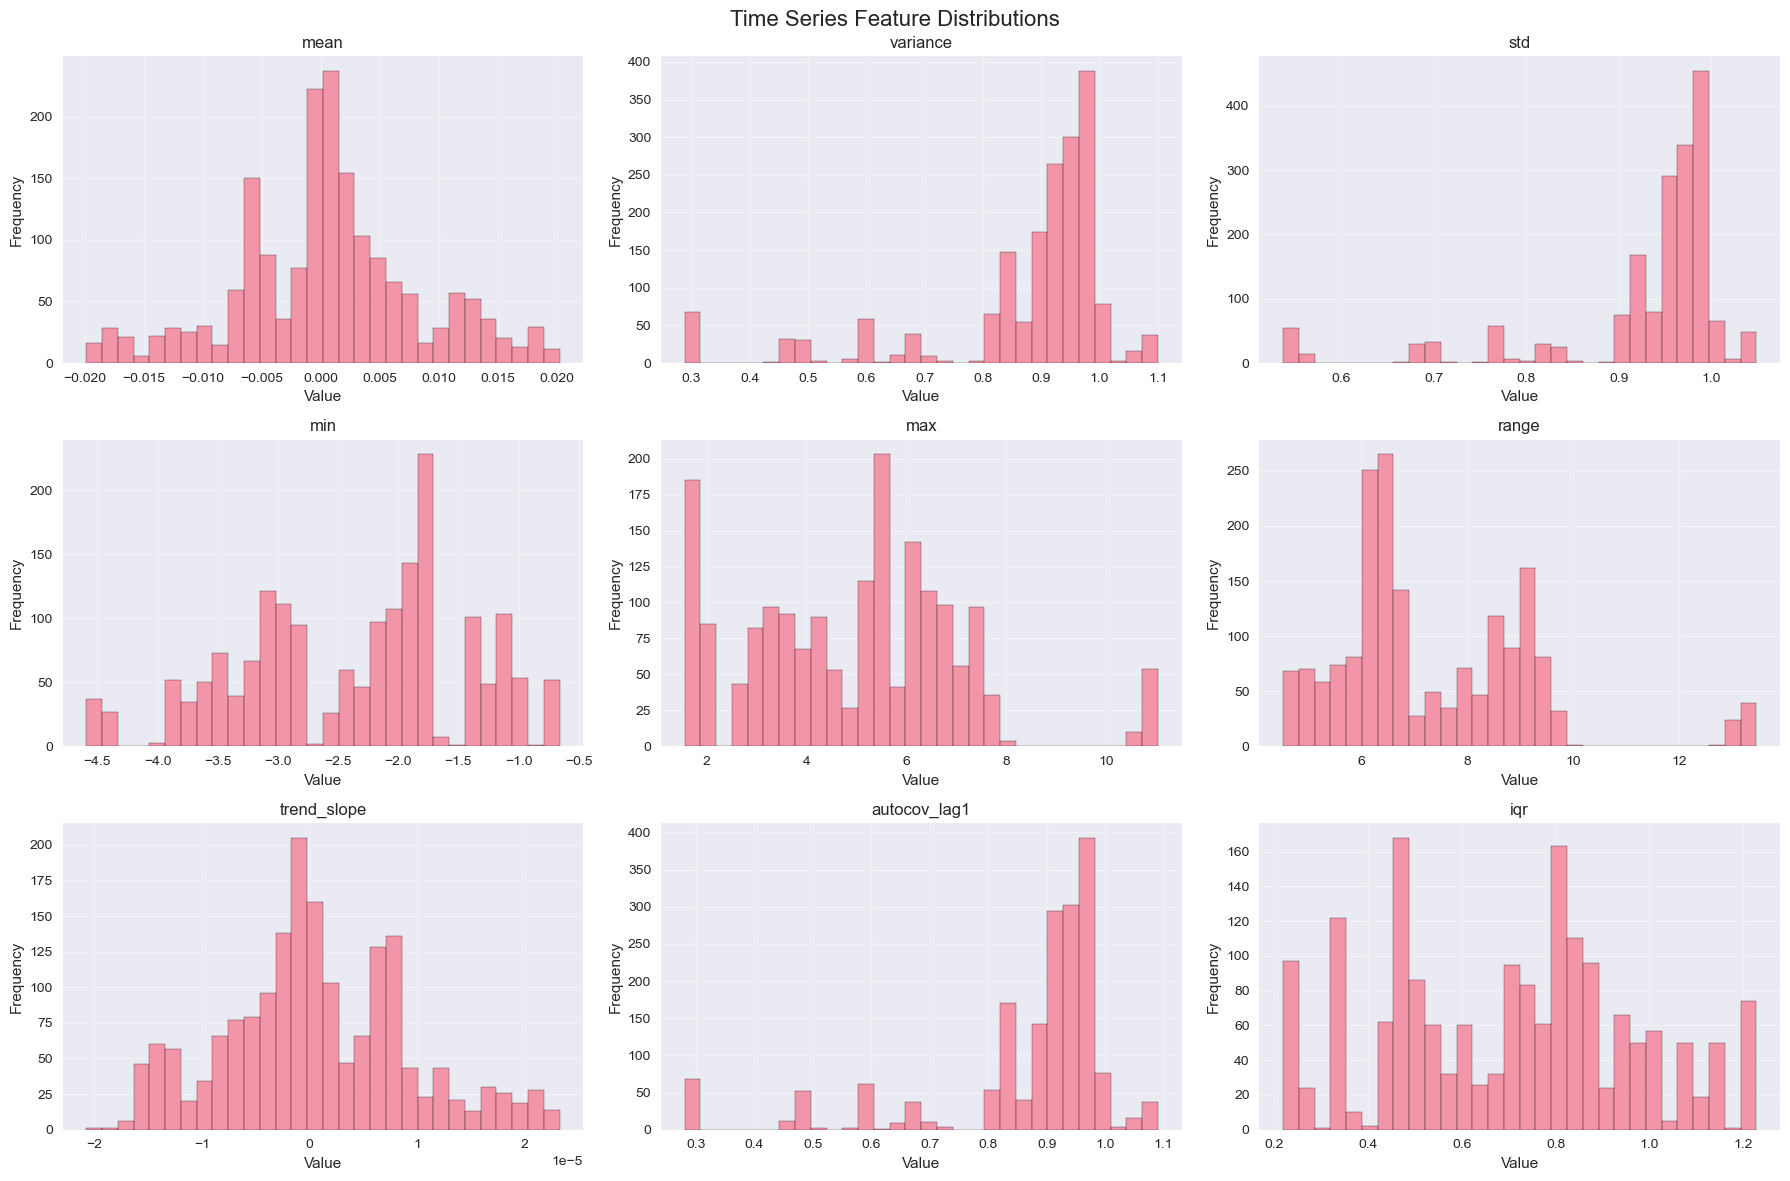

In [20]:
# Visualize feature distributions
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Time Series Feature Distributions', fontsize=16)

feature_cols = ['mean', 'variance', 'std', 'min', 'max', 'range', 'trend_slope', 'autocov_lag1', 'iqr']
for idx, col in enumerate(feature_cols):
    ax = axes[idx // 3, idx % 3]
    ax.hist(features_df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(f'{col}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(code_path / 'time_series_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Summary statistics
print("="*60)
print("TIME SERIES ANALYSIS SUMMARY")
print("="*60)
print(f"\n1. Data Overview:")
print(f"   - ECG signal analyzed: Lead II channel")
total_samples = sum([len(ts) for ts in time_series_dict.values()])
print(f"   - Total signal samples: {total_samples:,}")
print(f"   - Unique subjects: {len(time_series_dict):,}")
print(f"   - Subjects with time series (≥100 samples): {len(time_series_dict):,}")

print(f"\n2. Preprocessing:")
print(f"   - Applied offset translation removal")
print(f"   - Applied amplitude scaling (z-normalization)")
print(f"   - Applied linear trend removal")
print(f"   - Applied noise filtering (moving average)")

print(f"\n3. Approximation (PAA):")
avg_compression = np.mean([r['original_length'] / r['num_segments'] 
                           for r in paa_results.values()])
print(f"   - Average compression ratio: {avg_compression:.2f}x")
print(f"   - Average segments per series: {np.mean([r['num_segments'] for r in paa_results.values()]):.1f}")

print(f"\n4. Feature Extraction:")
print(f"   - Number of features extracted: {len(features_df.columns)}")
print(f"   - Features: {', '.join(features_df.columns.tolist())}")

print(f"\n5. Time Series Length Statistics:")
ts_lengths = [len(data['preprocessed']) for data in preprocessed_series.values()]
print(f"   - Mean length: {np.mean(ts_lengths):.1f} samples")
print(f"   - Median length: {np.median(ts_lengths):.1f} samples")
print(f"   - Min length: {np.min(ts_lengths)} samples")
print(f"   - Max length: {np.max(ts_lengths)} samples")

print("\n" + "="*60)


TIME SERIES ANALYSIS SUMMARY

1. Data Overview:
   - ECG signal analyzed: Lead II channel
   - Total signal samples: 8,930,000
   - Unique subjects: 1,786
   - Subjects with time series (≥100 samples): 1,786

2. Preprocessing:
   - Applied offset translation removal
   - Applied amplitude scaling (z-normalization)
   - Applied linear trend removal
   - Applied noise filtering (moving average)

3. Approximation Methods:
   PAA:
   - Average compression ratio: 500.00x
   - Average segments per series: 10.0
   SAX:
   - Average compression ratio: 500.00x
   - Average segments per series: 10.0
   - Alphabet size: 4
   DFT:
   - Number of coefficients: 20
   - Average compression ratio: 250.00x

4. Feature Extraction:
   - Number of features extracted: 13
   - Features: mean, variance, std, min, max, range, median, trend_slope, trend_intercept, autocov_lag1, q25, q75, iqr

5. Time Series Length Statistics:
   - Mean length: 5000.0 samples
   - Median length: 5000.0 samples
   - Min length: 

In [ ]:
# Save results
output_path = data_path / '3.1_time_series_features.csv'
features_df.to_csv(output_path)
print(f"Saved time series features to: {output_path}")

# Save PAA results summary
paa_summary = pd.DataFrame({
    'subject_id': list(paa_results.keys()),
    'original_length': [r['original_length'] for r in paa_results.values()],
    'paa_segments': [r['num_segments'] for r in paa_results.values()],
    'compression_ratio': [r['original_length'] / r['num_segments'] for r in paa_results.values()]
})
paa_output_path = data_path / '3.1_time_series_paa_summary.csv'
paa_summary.to_csv(paa_output_path, index=False)
print(f"Saved PAA summary to: {paa_output_path}")

# Save SAX results summary
sax_summary = pd.DataFrame({
    'subject_id': list(sax_results.keys()),
    'original_length': [r['original_length'] for r in sax_results.values()],
    'sax_segments': [r['num_segments'] for r in sax_results.values()],
    'compression_ratio': [r['original_length'] / r['num_segments'] for r in sax_results.values()]
})
sax_output_path = data_path / '3.1_time_series_sax_summary.csv'
sax_summary.to_csv(sax_output_path, index=False)
print(f"Saved SAX summary to: {sax_output_path}")

# Save DFT results summary
dft_summary = pd.DataFrame({
    'subject_id': list(dft_results.keys()),
    'original_length': [r['original_length'] for r in dft_results.values()],
    'dft_coefficients': [r['n_coefficients'] for r in dft_results.values()],
    'compression_ratio': [r['original_length'] / r['n_coefficients'] for r in dft_results.values()]
})
dft_output_path = data_path / '3.1_time_series_dft_summary.csv'
dft_summary.to_csv(dft_output_path, index=False)
print(f"Saved DFT summary to: {dft_output_path}")


Saved time series features to: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/3.1_time_series_features.csv
Saved PAA summary to: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/3.1_time_series_paa_summary.csv
Saved SAX summary to: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/3.1_time_series_sax_summary.csv
Saved DFT summary to: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/3.1_time_series_dft_summary.csv


Saved SAX summary to: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/3.1_time_series_sax_summary.csv
Saved DFT summary to: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/3.1_time_series_dft_summary.csv
